In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install wandb

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,models
from torch.utils.data import Dataset,DataLoader
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

import cv2
import os
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import csv
from shutil import copyfile
#import wandb
from copy import deepcopy
from sklearn.manifold import TSNE

In [ ]:
# wandb.login()
# api = wandb.Api()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# dataset = api.artifact("ankitdipto/CV-in-Retail/GP-Test:v0")
# dataset.download()
#MODEL = api.artifact("ankitdipto/CV-in-Retail/VGG16_c4_c5-hard-ngtv-GAN:v0")
#MODEL.download()

'./artifacts/GP-Test:v0'

In [ ]:
#!unzip -q /content/drive/MyDrive/datasets/TRAIN-embed.zip -d ./
#!ls /content/artifacts/GP-Test:v0/GP-180/test | wc -l
#!unzip -q "/content/drive/MyDrive/ML_MODELS/extGAN.zip" -d ./
!ln -s /content/drive/MyDrive/datasets/GP-180
!ln -s /content/drive/MyDrive/datasets/Grozi-3.2k-mine/Food
!ln -s /content/drive/MyDrive/datasets/Grozi-3.2k-mine/TRAIN-embed

In [ ]:
!ls /content/TRAIN-embed | wc -l

3235


In [ ]:
TRAIN_DIR = "/content/TRAIN-embed"
TEST_DIR = "/content/GP-180/test"
REF_DIR = "/content/GP-180/train"
#ROOT_DIR = "/content/artifacts/GP-Test:v0/GP-180/train"
#TEST_DIR = "/content/artifacts/GP-Test:v0/GP-180/test"
# SAVE_DIR = "/content/drive/MyDrive/ML_MODELS"
PATH_LABELS = "/content/GP-180/GP-180-labels.csv"
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
GPU = torch.device('cuda',index = 0)
CPU = torch.device('cpu')

In [ ]:
from GAN.models import *

In [ ]:
gen = Generator()
gan_ckpt_dir = "/content/GAN/generator"
checkpoint = tf.train.Checkpoint(generator=gen)
latest = tf.train.latest_checkpoint(gan_ckpt_dir)
checkpoint.restore(latest)

In [ ]:
def load_tf_image(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)
  img = tf.cast(image, tf.float32)
  return img

In [ ]:
img = cv2.imread("/content/GP-180/test/s3_112_8.jpg")
print(img.shape)

(727, 413, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


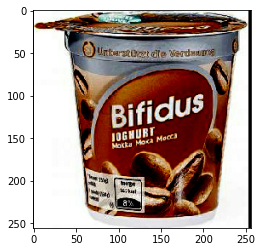

Output Image 0.00062024593 0.46178842 0.9200185


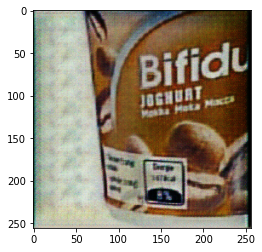

In [ ]:
img_path = "/content/GP-180/train/1467.jpg"
img = load_tf_image(img_path)

img = preprocess_image(img)
plt.imshow(img)
plt.show()

#anchor_img = tf.convert_to_tensor(img, dtype = tf.float32)
img = load_tf_image(img_path)
#img = cv2.imread(img_path)
#print(img.shape)

img = randomCrop(img,0.7,0.7)

img = tf.convert_to_tensor(img,dtype = tf.float32)
img = preprocess_image(img)
anchor_img = tf.expand_dims(img, axis = 0)
anchor_img = gen(anchor_img,training= True)
anchor_img = tf.squeeze(anchor_img,axis=0).numpy() * 0.5 + 0.5
# print(anchor_img.shape)
print("Output Image",anchor_img.min(),anchor_img.mean(),anchor_img.max())
# print(anchor_img)
plt.imshow(anchor_img)
plt.show()

#print(anchor_img)

In [ ]:
img_list = []
img_list_test = []
img_list_ref = []

for (root,dirs,files) in os.walk(TRAIN_DIR):
    for file in files:
        img_list.append(file)

for (root,dirs,files) in os.walk(TEST_DIR):
    for file in files:
        img_list_test.append(file)

for (root,dirs,files) in os.walk(REF_DIR):
    for file in files:
        img_list_ref.append(file)

print(img_list[:20])
print(img_list_test[:30])
print(img_list_ref[:20])

['food_3065.jpg', 'food_2801.jpg', 'food_2169.jpg', 'food_2400.jpg', 'food_1957.jpg', 'food_1369.jpg', 'food_2773.jpg', 'food_2077.jpg', 'food_2405.jpg', 'food_47.jpg', 'food_3212.jpg', 'food_437.jpg', 'food_730.jpg', 'food_1805.jpg', 'food_1309.jpg', 'food_2764.jpg', 'food_1928.jpg', 'food_2536.jpg', 'food_2945.jpg', 'food_122.jpg']
['s1_14_0.jpg', 's1_14_1.jpg', 's1_14_2.jpg', 's1_14_3.jpg', 's1_14_4.jpg', 's1_14_5.jpg', 's1_14_6.jpg', 's1_14_7.jpg', 's1_14_8.jpg', 's1_14_9.jpg', 's1_14_10.jpg', 's1_14_11.jpg', 's1_14_12.jpg', 's1_14_13.jpg', 's1_14_14.jpg', 's1_14_15.jpg', 's1_14_16.jpg', 's1_14_17.jpg', 's1_14_18.jpg', 's1_14_19.jpg', 's1_14_20.jpg', 's1_14_21.jpg', 's1_14_22.jpg', 's1_14_23.jpg', 's1_14_24.jpg', 's1_14_25.jpg', 's1_14_26.jpg', 's1_14_27.jpg', 's1_14_28.jpg', 's1_15_0.jpg']
['3005.jpg', '3000.jpg', '3006.jpg', '3009.jpg', '2999.jpg', '3010.jpg', '3011.jpg', '3026.jpg', '3001.jpg', '3032.jpg', '3002.jpg', '809.jpg', '807.jpg', '716.jpg', '718.jpg', '811.jpg', '810.j

In [ ]:
!rm -rf ANCHOR_DIR

In [ ]:
ANCHOR_DIR = "/content/drive/MyDrive/datasets/GP-180/anchors"
for img in os.listdir(TRAIN_DIR):
    src_path = os.path.join(TRAIN_DIR,img)
    anchor_path = os.path.join(ANCHOR_DIR,img[:-4] + "(a).jpg")        
    
    anchor_image = load_tf_image(src_path)
    #anchor_image = randomCrop(anchor_image,0.8,0.8)
    anchor_image = preprocess_image(anchor_image)
    anchor_image = tf.expand_dims(anchor_image, axis = 0)
    anchor_image = gen(anchor_image,training= True)
    anchor_image = tf.squeeze(anchor_image,axis=0).numpy() * 0.5 + 0.5   # Converting image[-1,1] to image[0,1]
    print(anchor_image.shape)
    anchor_image = anchor_image * 255.0
    anchor_image = cv2.cvtColor(anchor_image,cv2.COLOR_BGR2RGB)
    #anchor_image.dtype = np.uint8
    print(anchor_path)
    cv2.imwrite(anchor_path,anchor_image)
    #assert False

In [ ]:
img2label = {}
with open(PATH_LABELS) as csv_head:
    data = csv.reader(csv_head,delimiter = ',')
    for row in data:
        img2label[row[0]] = row[1]
print(img2label)

{'image': 'label', 's1_14_0.jpg': '3005', 's1_14_1.jpg': '3000', 's1_14_2.jpg': '3006', 's1_14_3.jpg': '3000', 's1_14_4.jpg': '3009', 's1_14_5.jpg': '2999', 's1_14_6.jpg': '3010', 's1_14_7.jpg': '3009', 's1_14_8.jpg': '2999', 's1_14_9.jpg': '3010', 's1_14_10.jpg': '3009', 's1_14_11.jpg': '3010', 's1_14_12.jpg': '2999', 's1_14_13.jpg': '3010', 's1_14_14.jpg': '3011', 's1_14_15.jpg': '3026', 's1_14_16.jpg': '3026', 's1_14_17.jpg': '3001', 's1_14_18.jpg': '3026', 's1_14_19.jpg': '3026', 's1_14_20.jpg': '3006', 's1_14_21.jpg': '3011', 's1_14_22.jpg': '3026', 's1_14_23.jpg': '3026', 's1_14_24.jpg': '3000', 's1_14_25.jpg': '3005', 's1_14_26.jpg': '3000', 's1_14_27.jpg': '3005', 's1_14_28.jpg': '3006', 's1_15_0.jpg': '3000', 's1_15_1.jpg': '3009', 's1_15_2.jpg': '2999', 's1_15_3.jpg': '3032', 's1_15_4.jpg': '3010', 's1_15_5.jpg': '3009', 's1_15_6.jpg': '3002', 's1_15_7.jpg': '2999', 's1_15_8.jpg': '3010', 's1_15_9.jpg': '3005', 's1_15_10.jpg': '3006', 's1_15_11.jpg': '3009', 's1_15_12.jpg': '

In [ ]:
# img2label = {}
# for img_name in img_list:
#     img2label[img_name] = img_name

In [ ]:
def gauss_blur(img):
    sigma = random.randint(0,4)
    if sigma > 0:
        kernel_size = 6 * sigma + 1
    else:
        kernel_size = 5
    #print(img.shape)
    blur = cv2.GaussianBlur(img,(kernel_size,kernel_size),sigma)
    return blur

def randomCrop(img, crop_ratio_min, crop_ratio_max):
    assert crop_ratio_min <= 1.0 and crop_ratio_min > 0
    assert crop_ratio_max <= 1.0 and crop_ratio_max > 0
    assert crop_ratio_max >= crop_ratio_min
    height, width = np.random.uniform(crop_ratio_min,crop_ratio_max,[2])
    height = int(height * img.shape[0])
    width = int(width * img.shape[1])
    x = np.random.randint(0, img.shape[1] - width)
    y = np.random.randint(0, img.shape[0] - height)
    img = img[y:y+height, x:x+width]
    return img

def change_brightness_saturation(img, bright_f=30, sat_f=0.3): 
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype("float32")
    h, s, v = cv2.split(hsv)
    value = np.random.randint(-bright_f,bright_f+1)
    v = v + value
    v = np.clip(v,0,255)
    sat_f = np.random.uniform(1-sat_f, 1+sat_f)
    s = s * sat_f
    s = np.clip(s,0,255)
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv.astype("uint8"), cv2.COLOR_HSV2RGB)
    return img

def mine_hard_negative(idx):
    ref_embed = embedding_positive[idx]
    bulk_ref_embed = torch.stack([ref_embed for x in range(embedding_positive.shape[0])])

    approx_dist = torch.linalg.norm(bulk_ref_embed - embedding_anchor, dim = 1)
    values, indices = approx_dist.sort()
    return indices[1]     # the 0th item will be identical ,so the hardest negative is the 1st item 

def mine_hard_negative_batch(embedding_matrix):
    hard_negative_batch = []
    #embedding_pos = None
    for ref_embed in embedding_matrix:
        bulk_ref_embed = torch.stack([ref_embed for x in range(embedding_matrix.shape[0])])
        approx_dist = torch.linalg.norm(bulk_ref_embed - embedding_matrix, dim = 1)
        values, indices = approx_dist.sort()
        hard_negative = embedding_matrix[indices[1]]
        hard_negative_batch.append(hard_negative)

    hard_negative_batch = torch.stack(hard_negative_batch,dim = 0)
    return hard_negative_batch

def manipulate(img):
    anchor_image = gauss_blur(img) 
    anchor_image = randomCrop(anchor_image, 0.74, 0.74)
    anchor_image = change_brightness_saturation(anchor_image, bright_f=30, sat_f=0.8)
    anchor_image = cv2.resize(anchor_image, (224, 224))
    
    return anchor_image

def manipulate_batch(imgs):
    anchor_image_batch = []
    for img in imgs:
        anchor_image = gauss_blur(img) 
        anchor_image = randomCrop(anchor_image, 0.74, 0.74)
        anchor_image = change_brightness_saturation(anchor_image, bright_f=30, sat_f=0.8)
        anchor_image = cv2.resize(anchor_image, (224, 224))
        anchor_img_batch.append(anchor_image)
    
    anchor_image_batch = torch.stack(anchor_image,dim = 0)
    return anchor_image_batch

def QualityCheck(emb_pos,emb_anc, sample_size):
    Q = []
    indices = random.sample(range(emb_anc.shape[0]), k = sample_size)
    for idx in indices:
        pos_anc_dist = torch.linalg.norm(emb_pos[idx] - emb_anc[idx], dim =0)
        hard_neg_idx = mine_hard_negative(idx)

        pos_ngtv_dist = torch.linalg.norm(emb_pos[idx] - emb_anc[hard_neg_idx])
        quality = pos_ngtv_dist - pos_anc_dist
        Q.append(quality)
    
    return Q

In [ ]:

class RetailDataset(Dataset):
    def __init__(self,root_dir,img_list,transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.img_list = img_list

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir,self.img_list[idx])
        image = cv2.imread(img_path)
        #image = load_tf_image(img_path)
        if image is None:
            print(img_path,idx,self.img_list[idx])
        image = cv2.resize(image,(224,224))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = torch.from_numpy(image)
        image = image.float() / 255
        image = torch.permute(image,[2,0,1])
        if self.transform:
            image = self.transform(image)
        return image

class AnchorPositiveFetcher(RetailDataset):
    def __init__(self,root_dir,img_list,transform = None):
        super().__init__(root_dir,img_list,transform)
        
    def __getitem__(self, idx_pos):
        positive_image = super().__getitem__(idx_pos)                  # The positive image
        
        anchor_path = os.path.join(self.root_dir,self.img_list[idx_pos])
       
        #-------------- RANDOM manipulation-----------
        
        anchor_image = cv2.imread(anchor_path)
        anchor_image = cv2.cvtColor(anchor_image,cv2.COLOR_BGR2RGB)
        anchor_image = manipulate(anchor_image)
        
        #---------------------------------------------

        anchor_image = torch.from_numpy(anchor_image)
        anchor_image = anchor_image.float() / 255.0
        anchor_image = torch.permute(anchor_image,[2,0,1])
        if self.transform:
            anchor_image = self.transform(anchor_image)                # The processed anchor image

            
        AP_pair = torch.stack([anchor_image,positive_image],dim = 0)
        return AP_pair

"""
class TripletRETAIL(RetailDataset):
    def __init__(self,root_dir,img_list,transform = None):
        super().__init__(root_dir,img_list,transform)

    
        
    def __getitem__(self, idx_pos):
        positive_image = super().__getitem__(idx_pos)                  # The positive image
        
        anchor_path = os.path.join(self.root_dir,self.img_list[idx_pos])
        
        
        
        # ------------ GAN generation ----------------
        # anchor_image = load_tf_image(anchor_path)
        # anchor_image = randomCrop(anchor_image,0.8,0.8)
        # anchor_image = preprocess_image(anchor_image)
        # anchor_image = tf.expand_dims(anchor_image, axis = 0)
        # anchor_image = gen(anchor_image,training= True)
        # anchor_image = tf.squeeze(anchor_image,axis=0).numpy() * 0.5 + 0.5   # Converting image[-1,1] to image[0,1]
        # anchor_image = cv2.resize(anchor_image,(224,224))
        #----------------------------------------------

        #-------------- RANDOM manipulation-----------
        
        anchor_image = cv2.imread(anchor_path)
        anchor_image = cv2.cvtColor(anchor_image,cv2.COLOR_BGR2RGB)
        anchor_image = manipulate(anchor_image)
        
        #---------------------------------------------

        anchor_image = torch.from_numpy(anchor_image)
        anchor_image = anchor_image.float() / 255.0
        anchor_image = torch.permute(anchor_image,[2,0,1])
        if self.transform:
            anchor_image = self.transform(anchor_image)                # The processed anchor image

        no_classes = super().__len__()
        neg_idx = random.randint(0,no_classes - 1)
        negative_image = super().__getitem__(neg_idx)                  # The negative image chosen randomly

        #idx_hard_neg = mine_hard_negative(idx_pos)
        #negative_image = super().__getitem__(idx_hard_neg)

        #print("anchor image mean",anchor_image.mean())        
        triplet = torch.stack([anchor_image,positive_image,negative_image],dim = 0)
        return triplet
"""

'\nclass TripletRETAIL(RetailDataset):\n    def __init__(self,root_dir,img_list,transform = None):\n        super().__init__(root_dir,img_list,transform)\n\n    \n        \n    def __getitem__(self, idx_pos):\n        positive_image = super().__getitem__(idx_pos)                  # The positive image\n        \n        anchor_path = os.path.join(self.root_dir,self.img_list[idx_pos])\n        \n        \n        \n        # ------------ GAN generation ----------------\n        # anchor_image = load_tf_image(anchor_path)\n        # anchor_image = randomCrop(anchor_image,0.8,0.8)\n        # anchor_image = preprocess_image(anchor_image)\n        # anchor_image = tf.expand_dims(anchor_image, axis = 0)\n        # anchor_image = gen(anchor_image,training= True)\n        # anchor_image = tf.squeeze(anchor_image,axis=0).numpy() * 0.5 + 0.5   # Converting image[-1,1] to image[0,1]\n        # anchor_image = cv2.resize(anchor_image,(224,224))\n        #---------------------------------------------

In [ ]:
#vgg13 = models.vgg13_bn(pretrained = True)
#vgg16 = models.vgg16_bn(pretrained = True)
#print(vgg16)
#resnet18 = models.resnet18(pretrained = True)
resnet18 = models.resnet18(pretrained = True)
res18 = deepcopy(resnet18)

# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

## Steps
1. Create a dataset returning triplets - **TripletMNIST** class from *datasets.py*, wrapper for MNIST-like classes
2. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
3. Define **triplet** network processing triplets - **TripletNet** wrapping *EmbeddingNet*
4. Train the network with **TripletLoss** - *losses.py*

In [ ]:
class Network13(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block_3 = vgg13.features[0:21]
        self.conv_block_4 = vgg13.features[21:28]
        self.conv_block_5 = vgg13.features[28:35]
        self.downsample = F.interpolate 

    def forward(self,x):
        x3 = self.conv_block_3(x)
        x4 = self.conv_block_4(x3)
        x5 = self.conv_block_5(x4)

        x4 = self.downsample(x4,size = (7,7))
        x3 = self.downsample(x3,size = (7,7))

        out = torch.cat([x3,x4,x5],dim = 1)
        return out

class Network16(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block_4 = vgg16.features[0:34]
        self.conv_block_5 = vgg16.features[34:44]
        #self.upsample = nn.Upsample(scale_factor = 2,mode = "nearest") 
        #self.downsample = F.interpolate
        self.maxpool_b4 = nn.MaxPool2d(kernel_size = (14,14))
        self.maxpool_b5 = nn.MaxPool2d(kernel_size = (7,7))

    def forward(self,x):
        x4 = self.conv_block_4(x)
        x5 = self.conv_block_5(x4)

        #x4 = self.downsample(x4,size = (7,7))
        x4 = self.maxpool_b4(x4)
        x5 = self.maxpool_b5(x5)
        #print(x4.shape,x5.shape)

        out = torch.cat([x4,x5],dim = 1)
        return out

class ResNet18_high_reso(nn.Module):
    def __init__(self,FREEZE = False):
        super(ResNet18_high_reso,self).__init__()
        self.entrypoint = nn.Sequential(res18.conv1,
                                        res18.bn1,
                                        res18.relu,
                                        res18.maxpool)
        #self.downConv = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        self.layer1 = res18.layer1
        self.layer2 = res18.layer2
        self.layer3 = res18.layer3
        self.layer4 = res18.layer4
        
        self.layer5 = nn.Conv2d(in_channels = 512,out_channels = 512, kernel_size = 3,stride = 1)

        self.maxpool_b4 = nn.MaxPool2d(kernel_size = (14,14))
        self.maxpool_b5 = nn.MaxPool2d(kernel_size = (7,7))
        
        #self.fc1 = nn.Linear(in_features = 768,out_features = 1024, bias = True)

        if FREEZE:
            self.freeze_backbone()

    def freeze_backbone(self):
        self.entrypoint.requires_grad_(False)
        self.layer1.requires_grad_(False)
        self.layer2.requires_grad_(False)
        self.layer3.requires_grad_(False)
        self.layer4.requires_grad_(False)

    def forward(self,X):
        X0 = self.entrypoint(X)
        X1 = self.layer1(X0)
        X2 = self.layer2(X1)
        X3 = self.layer3(X2)
        X4 = self.layer4(X3)
        X5 = self.layer5(X4)

        #print(X5.shape)
        x4_flat = self.maxpool_b4(X4)
        x5_flat = self.maxpool_b5(X5)
        
        out = torch.cat([x4_flat,x5_flat],dim = 1)
        #print(out.shape)
        #assert False
        out = out.view(X.shape[0],-1)
        return out

class ResNet18(nn.Module):
    def __init__(self,FREEZE = False):
        super(ResNet18,self).__init__()
        self.entrypoint = nn.Sequential(res18.conv1,
                                        res18.bn1,
                                        res18.relu,
                                        res18.maxpool)
        #self.downConv = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        self.layer1 = res18.layer1
        self.layer2 = res18.layer2
        self.layer3 = res18.layer3
        self.layer4 = res18.layer4
        self.maxpool_b3 = nn.MaxPool2d(kernel_size = (14,14))
        self.maxpool_b4 = nn.MaxPool2d(kernel_size = (7,7))
        #self.maxpool_b2 = nn.MaxPool2d(kernel_size = (28,28))
        #self.fc1 = nn.Linear(in_features = 768,out_features = 1024, bias = True)

        if FREEZE:
            self.freeze_backbone()

    def freeze_backbone(self):
        self.entrypoint.requires_grad_(False)
        self.layer1.requires_grad_(False)
        self.layer2.requires_grad_(False)
        self.layer3.requires_grad_(False)
        #self.layer4.requires_grad_(False)

    def forward(self,X):
        X0 = self.entrypoint(X)
        X1 = self.layer1(X0)
        X2 = self.layer2(X1)
        X3 = self.layer3(X2)
        X4 = self.layer4(X3)
        
        x3_flat = self.maxpool_b3(X3)
        x4_flat = self.maxpool_b4(X4)
        
        out = torch.cat([x3_flat,x4_flat],dim = 1)
        out = out.view(X.shape[0],-1)
        #out = self.fc1(out)

        return out

In [ ]:
del model

In [ ]:
#del model
model = ResNet18()
unfrozen_params = [p for p in model.parameters() if p.requires_grad == True]

In [ ]:
input = torch.rand(1,3,448,448)
output = model(input)
print(output.shape)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([1, 3072])


In [ ]:
model.to(GPU)
pass

In [ ]:
BATCH_SIZE = 124

tsfm = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
# train_ds = TripletRETAIL(TRAIN_DIR,img_list,tsfm)
# train_dl = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = False)

train_ds = AnchorPositiveFetcher(TRAIN_DIR,img_list,tsfm)
train_dl = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = False)

ref_ds = RetailDataset(REF_DIR,img_list_ref,tsfm)
ref_dl = DataLoader(ref_ds,batch_size = BATCH_SIZE, shuffle = False)

test_ds = RetailDataset(TEST_DIR,img_list_test,tsfm)
test_dl = DataLoader(test_ds, batch_size = BATCH_SIZE * 2, shuffle = False)

stocks_ds = RetailDataset(TRAIN_DIR,img_list,tsfm)
stocks_dl = DataLoader(stocks_ds, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
MARGIN = 1
loss_fn = nn.TripletMarginLoss(margin = MARGIN)
INIT_LR = 1e-4
EPOCHS = 15
trainable_params = [p for p in model.parameters() if p.requires_grad == True]
optimizer = optim.Adam(trainable_params, lr = INIT_LR)
#scheduler = optim.lr_scheduler.StepLR(optimizer,step_size = 20, gamma = 0.1)
#scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
log_interval = 1
test_interval = 1

In [ ]:
run = wandb.init(project = "CV-in-Retail", name = "vgg16_bn_c4+c5_pool_hdngtv")
#wandb.watch(model,log_freq = 10)

wandb: Currently logged in as: ankitdipto (use `wandb login --relogin` to force relogin)


In [ ]:
torch.cuda.empty_cache()

In [ ]:
del embedding_positive
del embedding_anchor

In [ ]:
itr = iter(stocks_dl)
batch = next(itr).to(DEVICE)
output = model(batch)
embed_size = output.view(BATCH_SIZE,-1).shape[1]
#embed_size = 1024
embedding_positive = torch.randn(len(train_ds),embed_size).to(GPU)
embedding_anchor = torch.randn(len(train_ds),embed_size).to(GPU)

In [ ]:
#model.to(GPU)
print(embed_size)

768


In [ ]:
best_ckpt = {"model_state" : model.state_dict(),
            "optimizer_state" : optimizer.state_dict(),
            "epochs" : EPOCHS,
            "margin" : MARGIN,
            "init_lr" : INIT_LR,
            "loss" : float("inf")}

In [ ]:
def train(model,start_epoch,stop_epoch):
    global best_ckpt
    torch.cuda.empty_cache()
    model.train()
    for epoch in range(start_epoch,stop_epoch):
        print("epoch ",epoch)
        cost = 0
        avg_dist = 0
        for (i,batch_AP) in enumerate(tqdm(train_dl)):
            #print(f"Epoch {epoch},batch {i}")
            idx = i * BATCH_SIZE
            #triple = torch.permute(triple,[1,0,2,3,4])
            #triple = triple.to(DEVICE)
            
            curr_batch_size = batch_AP.shape[0]
            batch_AP = batch_AP.to(GPU)
            optimizer.zero_grad()

            batch_AP = torch.permute(batch_AP,[1,0,2,3,4])
            positive = batch_AP[0]
            anchor = batch_AP[1]
            
            positive_emb = model(positive).view(curr_batch_size,-1)
            anchor_emb = model(anchor).view(curr_batch_size,-1)

            negative_emb = mine_hard_negative_batch(positive_emb)

            #anchor, positive, negative = triple[0],triple[1] ,triple[2]
            
            
            #negative = model(negative).view(curr_batch_size,-1)

            positive_emb = positive_emb / torch.linalg.norm(positive_emb,ord=2,dim =1,keepdim = True)
            negative_emb = negative_emb / torch.linalg.norm(negative_emb, dim = 1 ,ord=2,keepdim = True)     # The vectors must be normalised to learn richer representations
            anchor_emb = anchor_emb / torch.linalg.norm(anchor_emb, dim = 1,ord =2, keepdim = True) 

            loss = loss_fn(anchor_emb,positive_emb,negative_emb)
            loss.backward()
            cost += loss.item()
        
            embedding_anchor[idx:idx + curr_batch_size] = anchor_emb.to(GPU)
            embedding_positive[idx :idx + curr_batch_size] = positive_emb.to(GPU)
            optimizer.step()
        
        # scheduler.step()
        if best_ckpt["loss"] > cost:
            best_ckpt = {"model_state" : model.state_dict(),
                "optimizer_state" : optimizer.state_dict(),
                "epochs" : epoch,
                "margin" : MARGIN,
                "init_lr" : INIT_LR,
                "loss" : cost}
        
        if epoch%log_interval == 0:
                            
            Q = QualityCheck(embedding_positive,embedding_anchor,300)
            Q_avg = sum(Q)/len(Q)
            
            #_,acc1,acc5,_ = test(model,20)
            #wandb.log({"Train Loss": cost})
            #wandb.log({"Embedding Quality":Q_avg})
            # wandb.log({"Val Accuracy top 1":acc1})
            # wandb.log({"Val Accuracy top 5":acc5})

            print(f"\nLoss at epoch {epoch} = {cost}, Embedding quality = {Q_avg}")
        
        if epoch > 0 and epoch % test_interval == 0:
            #pass
            print("Starting evaluation ....")
            ref_embeddings = extract_embeddings(ref_dl,model,embed_size)
            test_embeddings = extract_embeddings(test_dl,model,embed_size)
            preds ,acc1, acc5,acc10, acc20 = test(model,ref_embeddings,test_embeddings)
            print("The accuracies are:\n Top 1 accuracy = {0}\n Top 5 accuracy = {1}\n Top 10 accuracy = {2}\n Top 20 accuracy = {3}".format(acc1,acc5,acc10,acc20))


In [ ]:
#test_interval = 1
train(model,0,7)

epoch  0


100%|██████████| 27/27 [01:56<00:00,  4.32s/it]



Loss at epoch 0 = 21.85953712463379, Embedding quality = 0.08267968893051147
epoch  1


100%|██████████| 27/27 [01:58<00:00,  4.38s/it]



Loss at epoch 1 = 18.481571674346924, Embedding quality = 0.13674776256084442
Starting evaluation ....


100%|██████████| 947/947 [00:01<00:00, 680.61it/s]


The accuracies are:
 Top 1 accuracy = 0.7803590285110876
 Top 5 accuracy = 0.9049630411826821
 Top 10 accuracy = 0.9186906019007391
 Top 20 accuracy = 0.925026399155227
epoch  2


100%|██████████| 27/27 [01:59<00:00,  4.41s/it]



Loss at epoch 2 = 14.540885895490646, Embedding quality = 0.25822651386260986
Starting evaluation ....


100%|██████████| 947/947 [00:01<00:00, 678.33it/s]


The accuracies are:
 Top 1 accuracy = 0.7719112988384371
 Top 5 accuracy = 0.9049630411826821
 Top 10 accuracy = 0.9197465681098205
 Top 20 accuracy = 0.9503695881731784
epoch  3


100%|██████████| 27/27 [01:58<00:00,  4.37s/it]



Loss at epoch 3 = 11.474415451288223, Embedding quality = 0.3003343641757965
Starting evaluation ....


100%|██████████| 947/947 [00:01<00:00, 686.48it/s]


The accuracies are:
 Top 1 accuracy = 0.7275607180570222
 Top 5 accuracy = 0.8827877507919747
 Top 10 accuracy = 0.9049630411826821
 Top 20 accuracy = 0.9313621964097148
epoch  4


100%|██████████| 27/27 [02:00<00:00,  4.46s/it]



Loss at epoch 4 = 9.880728164687753, Embedding quality = 0.3424988090991974
Starting evaluation ....


100%|██████████| 947/947 [00:01<00:00, 672.00it/s]


The accuracies are:
 Top 1 accuracy = 0.7412882787750792
 Top 5 accuracy = 0.9007391763463569
 Top 10 accuracy = 0.9186906019007391
 Top 20 accuracy = 0.941921858500528
epoch  5


100%|██████████| 27/27 [01:59<00:00,  4.44s/it]



Loss at epoch 5 = 8.692484200000763, Embedding quality = 0.36326131224632263
Starting evaluation ....


100%|██████████| 947/947 [00:01<00:00, 657.45it/s]


The accuracies are:
 Top 1 accuracy = 0.7465681098204857
 Top 5 accuracy = 0.9007391763463569
 Top 10 accuracy = 0.9134107708553326
 Top 20 accuracy = 0.925026399155227
epoch  6


100%|██████████| 27/27 [01:59<00:00,  4.43s/it]



Loss at epoch 6 = 7.54927085340023, Embedding quality = 0.3591865003108978
Starting evaluation ....


100%|██████████| 947/947 [00:01<00:00, 690.39it/s]

The accuracies are:
 Top 1 accuracy = 0.7307286166842661
 Top 5 accuracy = 0.8986272439281943
 Top 10 accuracy = 0.9165786694825766
 Top 20 accuracy = 0.9303062302006336


In [ ]:
Q = QualityCheck(embedding_positive,embedding_anchor,900)
Q_avg = sum(Q)/len(Q)
print(Q_avg.item())

0.36224889755249023


In [ ]:
cost = 0
for (i,batch) in enumerate(tqdm(stocks_dl)):
    #print(f"batch {i}")
    idx = i * BATCH_SIZE
    #triple = torch.permute(triple,[1,0,2,3,4])
    batch = batch.to(DEVICE)
    
    optimizer.zero_grad()

    anchor, positive, negative = batch,batch,batch
    curr_batch_size = anchor.shape[0]
    # print(curr_batch_size)
    positive = model(positive).view(curr_batch_size,-1)
    #anchor = positive
    #negative = positive
    anchor = model(anchor).view(curr_batch_size,-1)
    negative = model(negative).view(curr_batch_size,-1)

    positive = positive / torch.linalg.norm(positive,ord=2,dim =1,keepdim = True)
    negative = negative / torch.linalg.norm(negative, dim = 1 ,ord=2,keepdim = True)     # The vectors must be normalised to learn richer representations
    anchor = anchor / torch.linalg.norm(anchor, dim = 1,ord =2, keepdim = True) 

    loss = loss_fn(anchor,positive,negative)
    loss.backward()
    #cost += loss.item()

    embedding_anchor[idx:idx + curr_batch_size] = anchor.to(GPU)
    embedding_pos[idx :idx + curr_batch_size] = positive.to(GPU)
    optimizer.step()


100%|██████████| 39/39 [01:08<00:00,  1.75s/it]


In [ ]:
PATH = os.path.join(SAVE_DIR,"VGG16-triplet:v2.pt")

In [ ]:
print(best_ckpt["loss"],best_ckpt["epochs"])

7.54927085340023 6


In [ ]:
print(best_ckpt)

In [ ]:
last_ckpt = deepcopy(best_ckpt)
last_ckpt["model_state"] = model.state_dict()
last_ckpt["loss"] = 5.378
last_ckpt["epochs"] = 252
last_ckpt["acc_top_1"] = 0.241
last_ckpt["acc_top_5"] = 0.433
last_ckpt["acc_top_10"] = 0.508

In [ ]:
#model2 = Network16()
model.load_state_dict(best_ckpt["model_state"])

<All keys matched successfully>

In [ ]:
best_ckpt["epochs"] = 96
best_ckpt["acc_top_1"] = 0.37
best_ckpt["acc_top_5"] = 0.61
best_ckpt["acc_top_10"] = 0.7

In [ ]:
artifact = wandb.Artifact("VGG16_c4_c5-dn-hdngt-proper",type = "model")

In [ ]:
# last_ckpt = {"Note" : "A vgg16 trained on actual dataset without learning rate scheduler",
#             "model_state" : model.state_dict(),
#             "optimizer_state" : optimizer.state_dict(),
#             "epochs" : EPOCHS,
#             "margin" : MARGIN,
#             "init_lr" : INIT_LR,
#             "loss" : 287.6784973144531}

torch.save(last_ckpt,"/content/VGG16-C4-C5-dn-hdngtv-ep252.pt")
artifact.add_file("/content/VGG16-C4-C5-dn-hdngtv-ep252.pt")
run.log_artifact(artifact)

In [ ]:
!ls /content/GP-embed-74/train | grep -i Food_Tea_54

In [ ]:
def distance(t1,t2):
    del_t = t1 - t2
    return torch.linalg.vector_norm(del_t)

In [ ]:
val_ds = RetailDataset(ROOT_DIR,img_list,tsfm)
val_dl = DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
sample = torch.permute(val_ds[0],[1,2,0]) * 250
sample = torch.clamp(sample,min = 0,max = 255)
plt.imshow(sample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [ ]:
torch.cuda.empty_cache()
model2 = Network16()
ckpt = torch.load("/content/artifacts/VGG16_c4_c5-hard-ngtv-GAN:v0/VGG16-C4-C5-hard-neg-gan.pt", map_location = DEVICE)
model2.load_state_dict(ckpt["model_state"])

<All keys matched successfully>

In [ ]:
ckpt = torch.load("/content/artifacts/VGG13_c3_c4_c5-hard-ngtv:v0/VGG13-triplet-hard-neg.pt", map_location = DEVICE)
model.load_state_dict(ckpt["model_state"])

<All keys matched successfully>

In [ ]:
#model2 = Network16()
model2.to(GPU)
pass

In [ ]:
def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model, D):

    embedder_dim = D

    with torch.no_grad():
        model.eval()
        embeddings = torch.zeros((len(dataloader.dataset), embedder_dim)).to(GPU)
    
        k = 0
        for (nb,batch) in enumerate(tqdm(dataloader)):
            batch = batch.to(DEVICE)
            batch_size = batch.shape[0]
            output = model(batch).view(batch_size,-1)
            output = output / torch.linalg.norm(output,ord=2,dim =1,keepdim = True)
            embeddings[k : k + batch_size] = output
            k += batch_size

    return embeddings

In [ ]:
modelf = ResNet18()
modelf.load_state_dict(best_ckpt["model_state"])

<All keys matched successfully>

In [ ]:
_ = modelf.to(GPU)

In [ ]:
ref_embeddings = extract_embeddings(ref_dl,modelf,embed_size)
test_embeddings = extract_embeddings(test_dl,modelf,embed_size)

100%|██████████| 4/4 [00:10<00:00,  2.75s/it]


In [ ]:
len(ref_ds)

184

In [ ]:
#!rm /content/TRAIN-embed/food_2668.jpg

img_list = []
img_list_test = []

for (root,dirs,files) in os.walk(TRAIN_DIR):
    for file in files:
        img_list.append(file)

for (root,dirs,files) in os.walk(TEST_DIR):
    for file in files:
        img_list_test.append(file)
print(img_list[:12])
print(img_list_test[:10])

BATCH_SIZE = 128

tsfm = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
train_ds = TripletRETAIL(TRAIN_DIR,img_list,tsfm)
train_dl = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = False)

test_ds = RetailDataset(TEST_DIR,img_list_test,tsfm)
test_dl = DataLoader(test_ds, batch_size = BATCH_SIZE * 2, shuffle = False)

stocks_ds = RetailDataset(TRAIN_DIR,img_list,tsfm)
stocks_dl = DataLoader(stocks_ds, batch_size = BATCH_SIZE, shuffle = False)

['food_1072.jpg', 'food_2284.jpg', 'food_2077.jpg', 'food_681.jpg', 'food_2381.jpg', 'food_3109.jpg', 'food_62.jpg', 'food_3071.jpg', 'food_159.jpg', 'food_2940.jpg', 'food_887.jpg', 'food_1837.jpg']
['food_1072.jpg', 'food_2284.jpg', 'food_2077.jpg', 'food_681.jpg', 'food_2381.jpg', 'food_3109.jpg', 'food_62.jpg', 'food_3071.jpg', 'food_159.jpg', 'food_2940.jpg']


In [ ]:
#!rm /content/TRAIN-embed/food_2282.jpg

In [ ]:
@torch.no_grad()
def validate(model,idx):
    outputs = None
    model.eval()
    for (i,batch) in enumerate(val_dl):
        batch = batch.to(DEVICE)
        index = i * BATCH_SIZE
        curr_batch_size = min(BATCH_SIZE, len(val_ds) - index)
        
        embed = model(batch).view(curr_batch_size,-1)
        embed = embed.cpu()
        print(embed.mean())
        if outputs is not None:
            outputs = torch.cat([outputs,embed],dim = 0)
        else:
            outputs = embed        
    return outputs

@torch.no_grad()
def test(model,ref_embeddings,test_embeddings,subset_sz = None):
    stocks_ds = None
    model.eval()
    preds = []
    correct_top1 = 0
    correct_top5 = 0
    correct_top10 = 0
    correct_top20 = 0

    if subset_sz is None:
        sz = len(test_ds)
    else:
        sz = subset_sz

    for i in tqdm(range(sz)):
        sample_test = test_embeddings[i]
        sample_test_bundle = torch.stack([sample_test for _ in range(len(ref_ds))]).to(GPU)
        distances = torch.linalg.norm(sample_test_bundle - ref_embeddings, dim = 1)
        #print(distances.device)
        # assert distances.device == GPU
        values,indices = distances.sort()

        top20 = [ref_ds.img_list[x][:-4] for x in indices[:20]]
        top10 = [ref_ds.img_list[x][:-4] for x in indices[:10]] 
        top5 = [ref_ds.img_list[x][:-4] for x in indices[:5]]
        top1 = ref_ds.img_list[indices[0]][:-4]
        
        preds.append(top5)
        #print(top5)
        #print(img2label[test_ds.img_list[i]])
        if img2label[test_ds.img_list[i]] in top5:
            correct_top5 += 1

        if img2label[test_ds.img_list[i]] in top10:
            correct_top10 += 1

        if img2label[test_ds.img_list[i]] in top20:
            correct_top20 += 1

        if img2label[test_ds.img_list[i]] == top1:
            correct_top1 += 1

    return preds,correct_top1/sz,correct_top5/sz,correct_top10/sz,correct_top20/sz

In [ ]:
preds ,acc1, acc5,acc10, acc20 = test(modelf,ref_embeddings,test_embeddings)
print("The accuracies are:\n Top 1 accuracy = {0}\n Top 5 accuracy = {1}\n Top 10 accuracy = {2}\n Top 20 accuracy = {3}".format(acc1,acc5,acc10,acc20))

100%|██████████| 947/947 [00:01<00:00, 940.19it/s]

The accuracies are:
 Top 1 accuracy = 0.7307286166842661
 Top 5 accuracy = 0.8986272439281943
 Top 10 accuracy = 0.9165786694825766
 Top 20 accuracy = 0.9303062302006336


In [ ]:
PATH = "/content/drive/MyDrive/ML_MODELS/resnet18_embed_gp_3.2k_ep6_full_tune.pt"
torch.save({"model" : model.state_dict(),
            "epochs" : 6},PATH)

In [ ]:
PATH = "/content/drive/MyDrive/ML_MODELS/resnet18_embed_gp_3.2k_ep6_OHNM.pt"
torch.save(best_ckpt,PATH)

In [ ]:
Top 1 accuracy = 0.7729672650475184
 Top 5 accuracy = 0.8595564941921858
 Top 10 accuracy = 0.8732840549102429
 Top 20 accuracy = 0.9028511087645196

0.457233368532207


In [ ]:
tSNE = TSNE(n_components=2)
ref_embed_2d = tSNE.fit_transform(ref_embeddings.cpu().numpy())

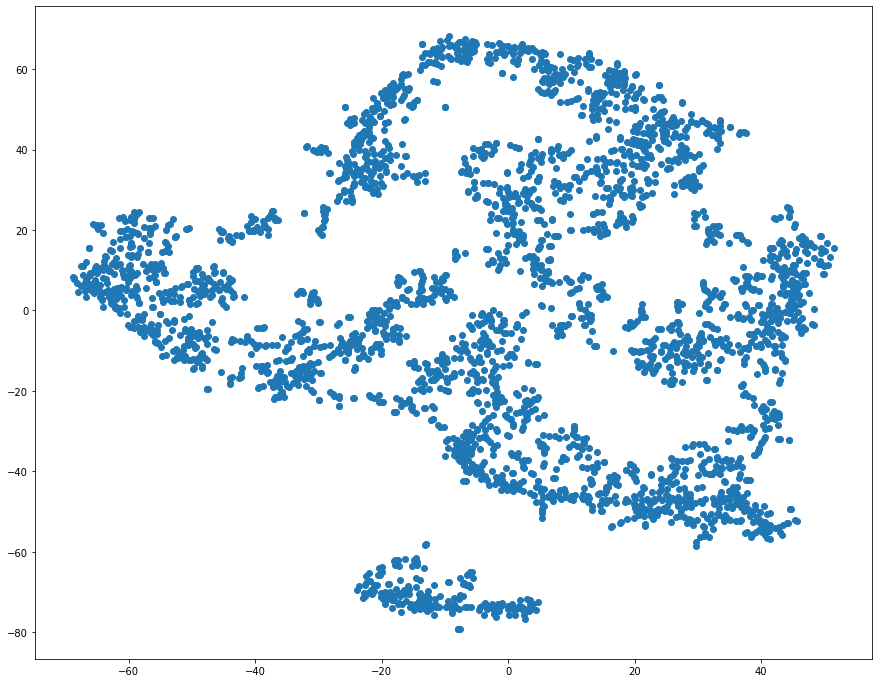

In [ ]:
plt.figure(figsize = (15,12))
plt.scatter(ref_embed_2d[:,0],ref_embed_2d[:,1])
plt.show()

In [ ]:
def plot_predictions(preds):
    for i in range(20):
        gtruth = cv2.imread(os.path.join(TEST_DIR,img_list_test[i]))
        img1 = cv2.imread(os.path.join(ROOT_DIR,preds[i][0] + ".jpg"))
        img2 = cv2.imread(os.path.join(ROOT_DIR,preds[i][1] + ".jpg"))
        img3 = cv2.imread(os.path.join(ROOT_DIR,preds[i][2] + ".jpg"))

        gtruth = cv2.cvtColor(gtruth,cv2.COLOR_BGR2RGB)
        img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)
        img3 = cv2.cvtColor(img3,cv2.COLOR_BGR2RGB)

        fig, axs = plt.subplots(1,4,figsize = (14,6))
        axs[0].imshow(gtruth)
        axs[0].set_title("Groud Truth")

        axs[1].imshow(img1)
        axs[1].set_title("Top-1")
        
        axs[2].imshow(img2)
        axs[2].set_title("Top-2")
        axs[3].imshow(img3)
        axs[3].set_title("Top-3")

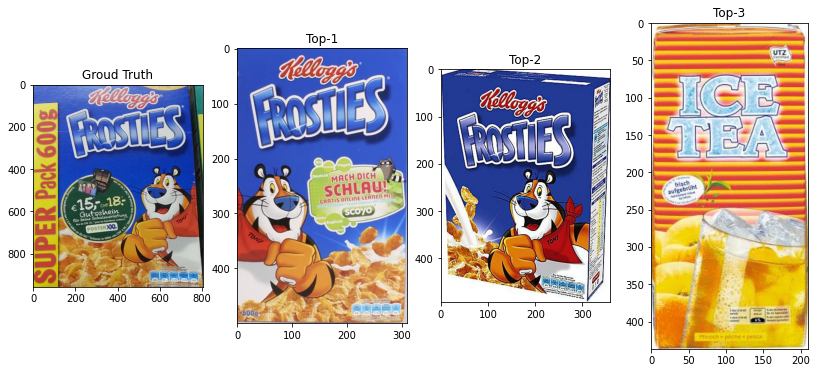

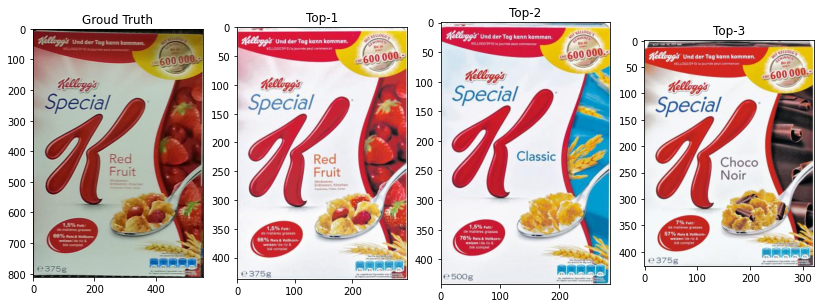

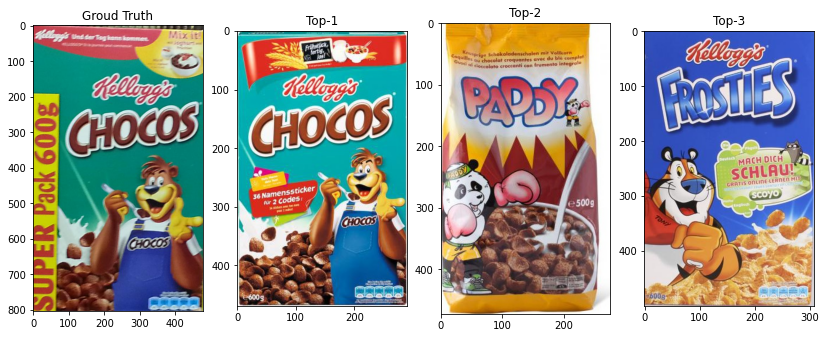

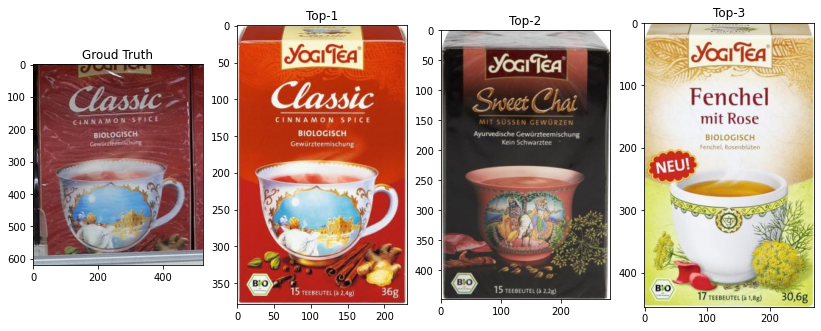

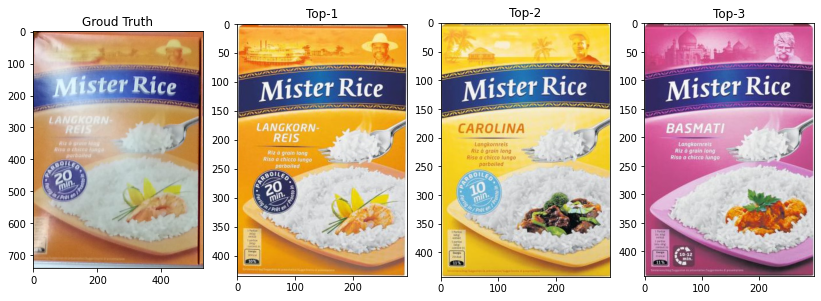

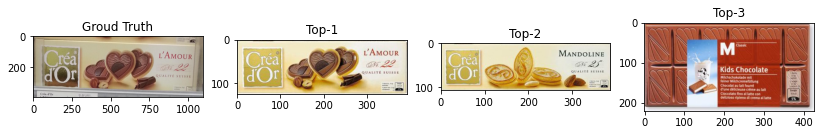

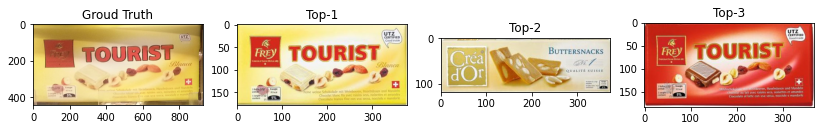

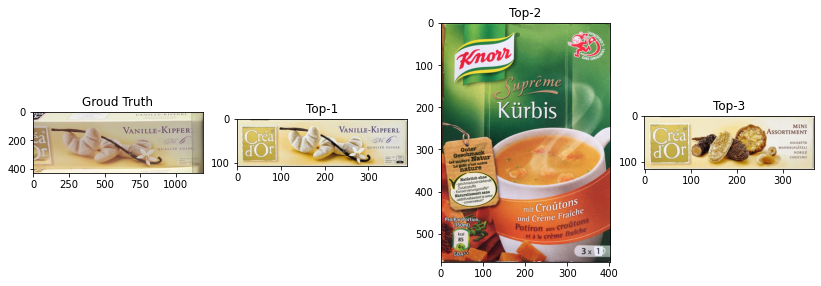

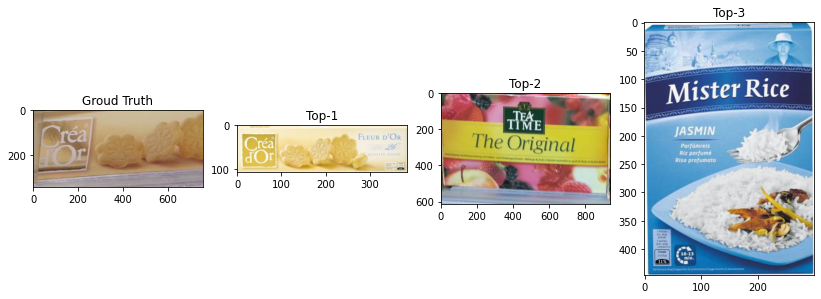

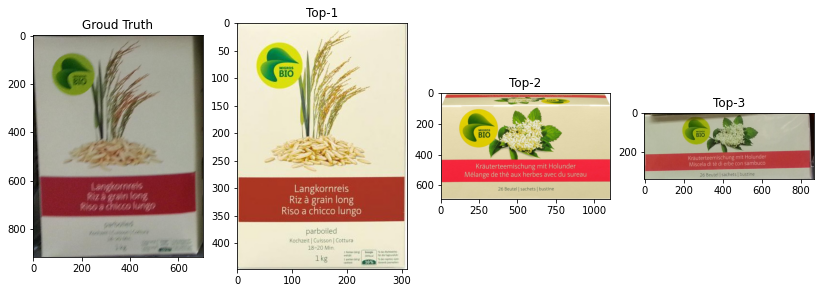

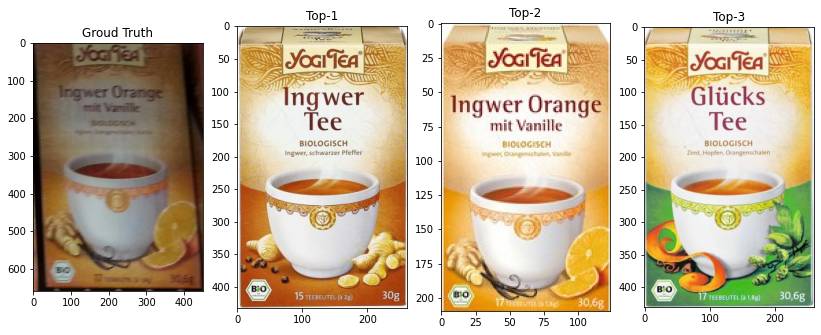

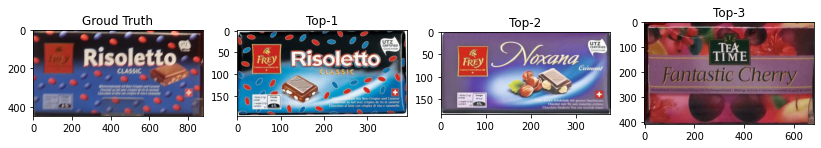

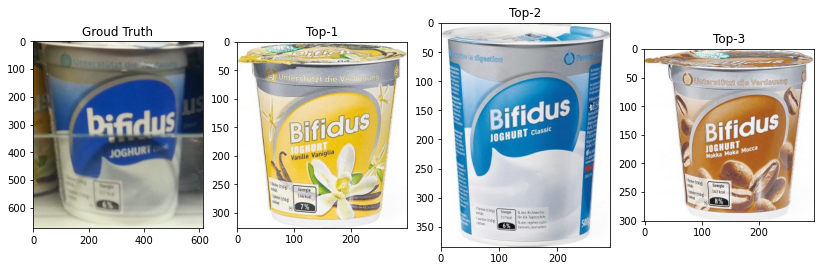

In [ ]:
plot_predictions(preds)

In [ ]:
outputs = validate(model,0)
print(outputs.shape)

tensor(0.0894)
tensor(0.0936)
tensor(0.0921)
tensor(0.1005)
torch.Size([49, 25088])


In [ ]:
print(outputs[18].mean())

tensor(0.0731)


In [ ]:
print(len(stocks_ds))

184


In [ ]:
#model.to(DEVICE)
model.to(torch.device('cpu'))
#del model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [ ]:
anchor_image = torch.permute(val_ds[0],[1,2,0]).numpy() * 255
anchor_image = gauss_blur(anchor_image) 
anchor_image = randomCrop(anchor_image, 0.8, 0.8)
anchor_image = change_brightness_saturation(anchor_image, bright_f=40, sat_f=0.8)
anchor_image = cv2.resize(anchor_image, (224, 224))
anchor_image = torch.from_numpy(anchor_image).float()
anchor_image = torch.permute(anchor_image,[2,0,1])
anchor_image = val_ds.transform(anchor_image) / 255.0
with torch.no_grad():
    sample = anchor_image
    sample = torch.stack([sample for i in range(len(val_ds))]).to(DEVICE)
    ref_embed = model(sample).view(len(val_ds),-1)
    print(ref_embed.shape)

torch.Size([49, 25088])


In [ ]:
ref_embed = ref_embed.to(torch.device('cpu'))
print(ref_embed.device)

cpu


In [ ]:
#distances = distance(outputs,ref_embed)
distances = torch.linalg.norm(outputs - ref_embed, dim = 1)
values,indices = distances.sort()
print(values[:11])
print(indices[:11])

tensor([72.7264, 73.0966, 73.8916, 76.1069, 81.8209, 82.4621, 82.8854, 83.7102,
        83.7749, 84.6016, 85.7280])
tensor([19,  7,  8, 46, 41, 21, 35, 36, 45, 30, 32])


In [ ]:
print(distances[:7])

tensor([ 90.2587,  90.5773, 103.1457, 172.1840,  97.8028,  93.5557,  84.6173])


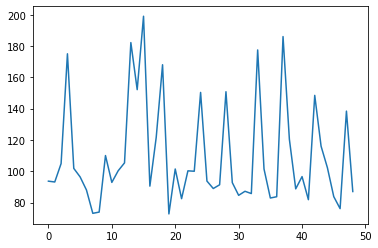

In [ ]:
plt.plot(distances)
plt.show()

In [ ]:
print(distances)

tensor([234.3698, 289.4332, 298.2442, 298.7901, 272.9360, 284.7640, 295.3423,
        283.4343, 273.9859, 275.0949, 291.1870, 297.7861, 292.5582, 277.6494,
        273.2768, 265.0824, 286.4151, 281.1884, 297.9932, 299.5201, 272.2085,
        290.6907, 278.5516, 286.2938, 278.8064, 278.0702, 292.3061, 258.7340,
        255.5603, 283.6424, 279.7805, 293.6757, 275.8965, 279.5657, 293.2570,
        270.7417, 301.5270, 279.2533, 277.0589, 277.2236, 291.4572, 277.7101,
        296.6182, 276.8777, 273.5479, 285.9225, 263.1229, 299.1874, 292.4741])


[tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0',
       grad_fn=<UnbindBackward>), tensor([0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        2.7554e-06], device='cuda:0', grad_fn=<UnbindBackward>), tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0002], device='cuda:0',
       grad_fn=<UnbindBackward>), tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0023], device='cuda:0',
       grad_fn=<UnbindBackward>), tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0021], device='cuda:0',
       grad_fn=<UnbindBackward>), tensor([0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        8.4739e-06], device='cuda:0', grad_fn=<UnbindBackward>), tensor([0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        6.6573e-06], device='cuda:0', grad_fn=<UnbindBackward>), tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0010], device='cuda:0',
       grad_fn=<UnbindBackward>), tensor([0.0000, 0.0000, 0.0000,  ...

In [ ]:
t = torch.stack([val_ds[0] for _ in range(10)])
print(t.shape)

torch.Size([10, 3, 224, 224])


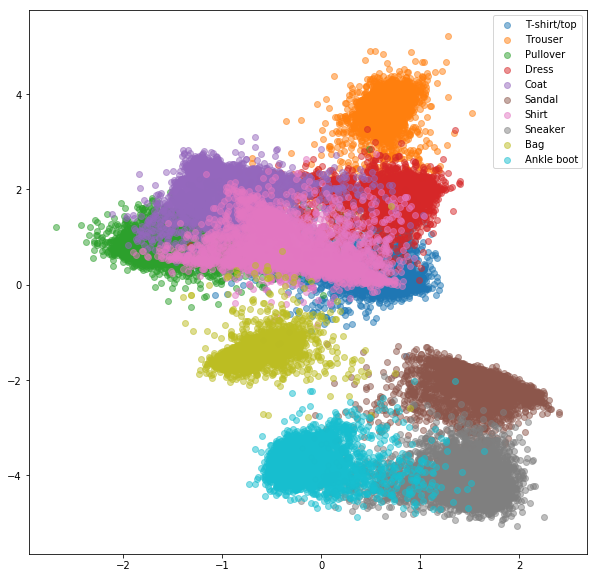

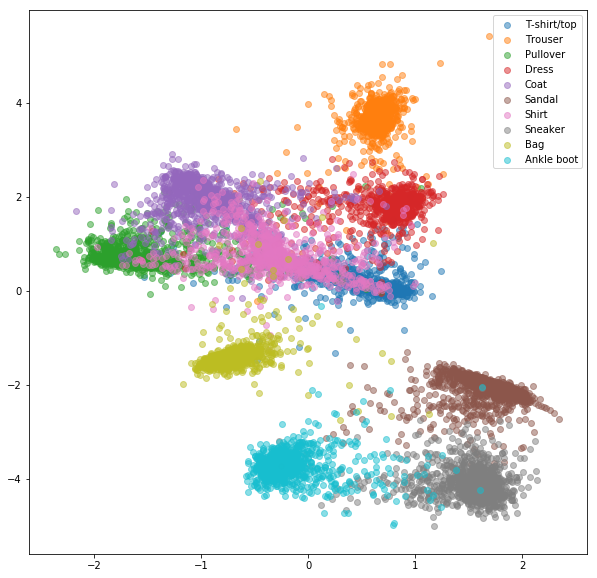

In [ ]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)

# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

## Online pair selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **PairSelector** that takes embeddings and original labels and returns valid pairs within a minibatch
5. Define **OnlineContrastiveLoss** that will use a *PairSelector* and compute *ContrastiveLoss* on such pairs
6. Train the network!

In [ ]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 250

In [ ]:
all_embeddings = fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.493998
Epoch: 1/20. Train set: Average loss: 0.2507
Epoch: 1/20. Validation set: Average loss: 0.1949
Train: [0/60000 (0%)]	Loss: 0.165879
Epoch: 2/20. Train set: Average loss: 0.1766
Epoch: 2/20. Validation set: Average loss: 0.1708
Train: [0/60000 (0%)]	Loss: 0.159209
Epoch: 3/20. Train set: Average loss: 0.1499
Epoch: 3/20. Validation set: Average loss: 0.1661
Train: [0/60000 (0%)]	Loss: 0.129778
Epoch: 4/20. Train set: Average loss: 0.1323
Epoch: 4/20. Validation set: Average loss: 0.1534
Train: [0/60000 (0%)]	Loss: 0.126551
Epoch: 5/20. Train set: Average loss: 0.1175
Epoch: 5/20. Validation set: Average loss: 0.1478
Train: [0/60000 (0%)]	Loss: 0.110542
Epoch: 6/20. Train set: Average loss: 0.1049
Epoch: 6/20. Validation set: Average loss: 0.1458
Train: [0/60000 (0%)]	Loss: 0.136336
Epoch: 7/20. Train set: Average loss: 0.0951
Epoch: 7/20. Validation set: Average loss: 0.1439
Train: [0/60000 (0%)]	Loss: 0.058131
Epoch: 8/20. Train set: Average loss: 0

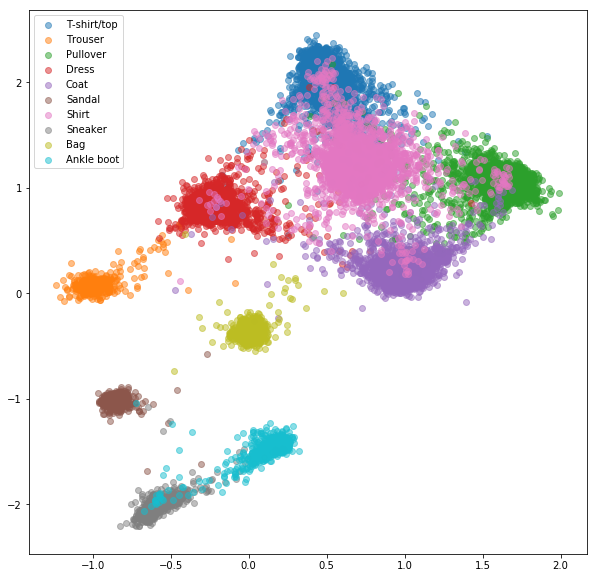

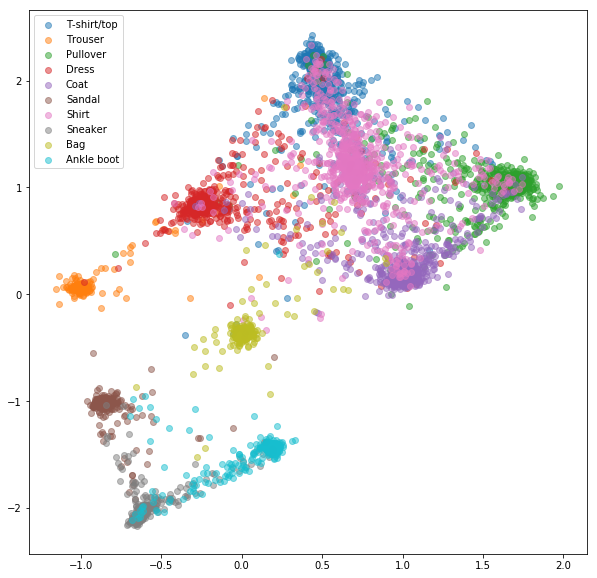

In [ ]:
train_embeddings_ocl, train_labels_ocl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_ocl, train_labels_ocl)
val_embeddings_ocl, val_labels_ocl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_ocl, val_labels_ocl)

## Online triplet selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **TripletSelector** that takes embeddings and original labels and returns valid triplets within a minibatch
5. Define **OnlineTripletLoss** that will use a *TripletSelector* and compute *TripletLoss* on such pairs
6. Train the network!

In [ ]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 150

In [ ]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

Train: [0/60000 (0%)]	Loss: 0.999639	Average nonzero triplets: 3000.0
Train: [37500/60000 (62%)]	Loss: 0.997169	Average nonzero triplets: 2497.5960264900664
Epoch: 1/20. Train set: Average loss: 1.0007	Average nonzero triplets: 2385.9205020920504
Epoch: 1/20. Validation set: Average loss: 0.8909	Average nonzero triplets: 2252.153846153846
Train: [0/60000 (0%)]	Loss: 1.134557	Average nonzero triplets: 2130.0
Train: [37500/60000 (62%)]	Loss: 0.992342	Average nonzero triplets: 2028.7549668874171
Epoch: 2/20. Train set: Average loss: 0.9942	Average nonzero triplets: 2020.702928870293
Epoch: 2/20. Validation set: Average loss: 1.0168	Average nonzero triplets: 1963.179487179487
Train: [0/60000 (0%)]	Loss: 1.016245	Average nonzero triplets: 2223.0
Train: [37500/60000 (62%)]	Loss: 0.995299	Average nonzero triplets: 1861.9933774834437
Epoch: 3/20. Train set: Average loss: 0.9963	Average nonzero triplets: 1852.1882845188284
Epoch: 3/20. Validation set: Average loss: 0.9350	Average nonzero triple

In [ ]:
train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)

In [ ]:
display_emb_online, display_emb, display_label_online, display_label = train_embeddings_ocl, train_embeddings_cl, train_labels_ocl, train_labels_cl
# display_emb_online, display_emb, display_label_online, display_label = val_embeddings_ocl, val_embeddings_cl, val_labels_ocl, val_labels_cl

x_lim = (np.min(display_emb_online[:,0]), np.max(display_emb_online[:,0]))
y_lim = (np.min(display_emb_online[:,1]), np.max(display_emb_online[:,1]))
x_lim = (min(x_lim[0], np.min(display_emb[:,0])), max(x_lim[1], np.max(display_emb[:,0])))
y_lim = (min(y_lim[0], np.min(display_emb[:,1])), max(y_lim[1], np.max(display_emb[:,1])))

plot_embeddings(display_emb, display_label, x_lim, y_lim)
plot_embeddings(display_emb_online, display_label_online, x_lim, y_lim)

In [ ]:
display_emb_online, display_emb, display_label_online, display_label = train_embeddings_otl, train_embeddings_tl, train_labels_otl, train_labels_tl
# display_emb_online, display_emb, display_label_online, display_label = val_embeddings_otl, val_embeddings_tl, val_labels_otl, val_labels_tl
x_lim = (np.min(display_emb_online[:,0]), np.max(display_emb_online[:,0]))
y_lim = (np.min(display_emb_online[:,1]), np.max(display_emb_online[:,1]))
x_lim = (min(x_lim[0], np.min(display_emb[:,0])), max(x_lim[1], np.max(display_emb[:,0])))
y_lim = (min(y_lim[0], np.min(display_emb[:,1])), max(y_lim[1], np.max(display_emb[:,1])))
plot_embeddings(display_emb, display_label, x_lim, y_lim)
plot_embeddings(display_emb_online, display_label_online, x_lim, y_lim)